In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pi = np.pi
NiterG = 10000
Niter = 10
dt = 0.00001
Umax = 311
SIZE = 29 #Número de barras do mortor+anel coletor
Cr = 2.38 #Conjugado de carga nominal

FALHA = 1

# Dados do Motor de Indução

p = 1
Jt = 0.023976
fv = 0.0014439

Ns = 156 #Número de voltas da bobina do estator
rs = 1.5 #Resitencia do estator
Ls1 = 0.007 #Indutância de dispersão do estator

nb = 28 #Número de barras do rotor
Rb = 0.000096940036 #resistência das barras
Re = 0.000005	#resistencia do endring
Lb = 0.00000028  #Auto indutância da barra do rotor
Le = 0.000000036 #Auto indutância do endring

r = 0.070  #Raio medio do entreferro
g = 0.00028  #Entreferro
l = 0.120 #Comprimento efetivo do rotor

mu  = 0.00000125663

Lms = (Ns / (2 * p)) * (Ns / (2 * p)) * ((np.pi * mu * l * r) / g)
Lsr = 4 / np.pi * Lms / Ns * np.sin(p * (2*np.pi) / (2*nb))

tam = 29

t = 0
teta = 0
om = 0
isa1 = 0
isb1 = 0
isc1 = 0

dL = np.zeros((34,34))
A = np.zeros((34,34))
b = np.zeros((34,34))
inv_L = np.zeros((34,34))
B = np.zeros((34,34))

x =  np.zeros((34))
U = np.zeros((34))
BU = np.zeros((34))
Ad =np.zeros((34))

# ir1 = 0
# ir2 = 0
# ir3 = 0
# ir4 = 0
# ir5 = 0
# ir6 = 0
# ir7 = 0
# ir8 = 0
# ir9 = 0
# ir10 = 0
# ir11 = 0
# ir12 = 0
# ir13 = 0
# ir14 = 0
# ir15 = 0
# ir16 = 0
# ir17 = 0
# ir18 = 0
# ir19 = 0
# ir20 = 0
# ir21 = 0
# ir22 = 0
# ir23 = 0
# ir24 = 0
# ir25 = 0
# ir26 = 0
# ir27 = 0
# ir28 = 0
# ire = 0
# om = 0
# teta = 0
# te = 0

R_r = np.zeros((SIZE,SIZE))
L_r = np.zeros((SIZE,SIZE))
L_sr = np.zeros((3, SIZE))
dL_sr = np.zeros((3, SIZE))
L_rs = np.zeros((SIZE,3))
dL_rs = np.zeros((SIZE,3))
R_s = np.zeros((3,3))
L_s = np.zeros((3,3))
L = np.zeros((SIZE+5,SIZE+5))
R = np.zeros((SIZE+5,SIZE+5))

results = np.zeros((NiterG,29))


In [3]:
def cos(a):
  return np.cos(a)

def sin(a):
  return np.sin(a)

In [4]:
def assemble_Rr():
  a = 2*(Rb + Re)
  b = -Rb
  c = -Re
  d = nb*Re

  for m in range(tam):
    for n in range(tam):
      if(m == 0 and n == tam-2):
        R_r[m][n] = b
      else:
        if(m == tam-2 and n == 0):
          R_r[m][n] = b
        elif(m == n and m != tam-1):
          R_r[m][n] = a
        elif(m + 1 == n and n != tam - 1):
          R_r[m][n] = b
        elif(m - 1 == n and m != tam - 1):
          R_r[m][n] = b
        elif(n == tam - 1):
          R_r[m][n] = c
        elif(m == tam - 1):
          R_r[m][n] = c
        else:
          R_r[m][n] = 0
  R_r[tam - 1][tam - 1] = d
  return True

In [5]:
def assemble_Lr():

  alpha = 2 * np.pi/nb
  Lkk = (mu * l * r / g) * (1 - alpha / (2 * pi)) * alpha
  Lki = -((mu * l * r) / g) * ((alpha * alpha) / (2 * pi))
  Ld = Lkk + 2 * (Le + Lb)
  Lt = Lki - Lb

  a = Ld
  b = Lt
  c = -Le
  d = nb*Le

  for m in range(tam):
    for n in range(tam):
      if(m == 0 and n == tam-2):
        L_r[m][n] = b
      else:
        if(m == tam-2 and n == 0):
          L_r[m][n] = b
        elif(m == n and m != tam-1):
          L_r[m][n] = a
        elif(m + 1 == n and n != tam - 1):
          L_r[m][n] = b
        elif(m - 1 == n and m != tam - 1):
          L_r[m][n] = b
        elif(n == tam - 1):
          L_r[m][n] = c
        elif(m == tam - 1):
          L_r[m][n] = c
        else:
          L_r[m][n] = 0
  L_r[tam - 1][tam - 1] = d
  return True

In [6]:
def assemble_Lsr():
  alpha = 2* np.pi/nb

  for m in range(3):
    for n in range(tam-1):
      if(m == 0):
        L_sr[m][n] = Lsr * cos(p * (teta + n * alpha + alpha / 2))
      if(m == 1):
        L_sr[m][n] = Lsr * cos(p * (teta + n * alpha + alpha / 2) - 2 * pi / 3)
      if(m == 2):
        L_sr[m][n] = Lsr * cos(p * (teta + n * alpha + alpha / 2) + 2 * pi / 3)
  return True

In [7]:
def assemble_dLsr():
  alpha = 2 * np.pi / nb
  K = -p*Lsr*om

  for m in range(3):
    for n in range(tam-1):
      if(m == 0):
        dL_sr[m][n] = K * sin(p * (teta + n * alpha + alpha / 2))
      if(m == 1):
        dL_sr[m][n] = K * sin(p * (teta + n * alpha + alpha / 2) - 2 * pi / 3)
      if(m == 2):
        dL_sr[m][n] = K * sin(p * (teta + n * alpha + alpha / 2) + 2 * pi / 3)
      

In [8]:
def assemble_Lrs():
  for m in range(tam):
    for n in range(3):
      L_rs[m][n] = L_sr[n][m]

def assemble_dLrs():
  for m in range(tam):
    for n in range(3):
      dL_rs[m][n] = dL_sr[n][m]
    
def assemble_R_s():
  R_s[0][0] = R_s[1][1] = R_s[2][2] = rs

def assemble_L_s():
  L_s[0][0] = L_s[1][1] = L_s[2][2] = Ls1 + Lms
  L_s[0][1] = L_s[0][2] = L_s[1][2] = L_s[1][0] = L_s[2][0] = L_s[2][1] = -0.5 * Lms


In [9]:
def assemble_L():
  assemble_L_s()
  assemble_Lsr()
  assemble_Lrs()
  assemble_Lr()

  for m in range(3):
    for n in range(3):
      L[m][n] = L_s[m][n]
  for m in range(3):
    for n in range(3,tam+3):
      L[m][n] = L_sr[m][n - 3]
  for m in range(3,tam+3):
    for n in range(3):
      L[m][n] = L_rs[m - 3][n]
  for m in range(3,tam+3):
    for n in range(3,tam+3):
      L[m][n] = L_r[m - 3][n - 3]
  L[tam + 3][tam + 3] = Jt
  L[tam + 3 + 1][tam + 3 + 1] = 1.0

In [10]:
def assemble_R():
  assemble_R_s()
  assemble_dLsr()
  assemble_dLrs()
  assemble_Rr()

  alpha = 2 * np.pi/nb

  for m in range(3):
    for n in range(3):
      R[m][n] = R_s[m][n]
  for m in range(3):
    for n in range(3,tam+3):
      R[m][n] = dL_sr[m][n - 3]
  for m in range(3,tam+3):
    for n in range(3):
      R[m][n] = dL_rs[m - 3][n]
  for m in range(3,tam+3):
    for n in range(3,tam+3):
      R[m][n] = R_r[m - 3][n - 3]
  for n in range(3,tam+2):
    X1 = p * (teta + (n - 3) * alpha + alpha / 2)
    X2 = p * (teta + (n - 3) * alpha + alpha / 2) - 2 * pi / 3
    X3 = p * (teta + (n - 3) * alpha + alpha / 2) + 2 * pi / 3
    R[tam + 3][n] = Lsr * p * (isa1 * sin(X1) + isb1 * sin(X2) + isc1 * sin(X3))
  R[tam + 3][tam + 3] = fv
  R[tam + 3 + 1][tam + 3] = -1.0
  

In [11]:
def calcul_de_U():
  # global U, Umax, pi
  fs = 50
  oms = 2 * pi * fs

  va1 = Umax * cos(oms*t)
  vb1 = Umax * cos(oms * t -2.0 * pi/3.0)
  vc1 = Umax * cos(oms * t + 2.0 * pi/3)

  U[0] = va1
  U[1] = vb1
  U[2] = vc1
  U[32] = -Cr
  U[32] = 0

In [12]:
def calcul_vecteur(d):
  assemble_L()
  assemble_R()
  # global R, L, U

  inv_L = np.linalg.inv(L)
  BU = R.dot(d)
  BU = U - BU
  c = inv_L.dot(BU)
  # print("d = ", d)
  # print("C = ",c)
  return c

In [13]:
# calcul_vecteur(z)

In [14]:
U

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
def runge_kutta4():
  Y0 = 0
  Y1 = 0
  Y2 = 0
  Y3 = 0
  dx = 0
  temp = 0
  global ir1, ir2, ir3, ir4, ir5, ir6, ir7, ir8, ir9, ir10, ir11, ir12, ir13, ir14, ir15, ir16, ir17, ir18, ir19, ir20, ir21, ir22, ir23, ir24, ir25, ir26, ir27, ir28, ire, om, teta, te

  calcul_de_U()
  # print("U = ", U)
  # print("x1 = ", x)
  Y0 = calcul_vecteur(x)
  # print("Y0 = ", Y0)
  dx = Y0*dt/2
  Y1 = x+dx

  # print("x2 = ", x)
  # print("Y1 = ", Y1)
  temp = calcul_vecteur(Y1)
  Y1 = temp
  dx = Y1*dt/2
  Y2 = x+dx
  # print("dx = ", dx)

  # print("x3 = ", x)
  # print("Y2 = ", Y2)
  temp = calcul_vecteur(Y2)
  Y2 = temp
  dx = Y2*dt
  Y3 = x+dx

  # print("temp = ", temp)
  # print("Y3 = ", Y3)
  temp = calcul_vecteur(Y3)
  Y3 = temp
  
  Y1 = Y1*2
  Y2 = Y2*2
  dx = (Y0 + Y1 + Y2 + Y3) * dt/6
  z = x+dx
  for i in range(34):
    x[i] = x[i]+dx[i]
  # print("x = ", x)
  # print("z = ", z)

  isa1 = z[0]
  isb1 = z[1]
  isc1 = z[2]
  ir1 = z[3]
  ir2 = z[4]
  ir3 = z[5]
  ir4 = z[6]
  ir5 = z[7]
  ir6 = z[8]
  ir7 = z[9]
  ir8 = z[10]
  ir9 = z[11]
  ir10 = z[12]
  ir11 = z[13]
  ir12 = z[14]
  ir13 = z[15]
  ir14 = z[16]
  ir15 = z[17]
  ir16 = z[18]
  ir17 = z[19]
  ir18 = z[20]
  ir19 = z[21]
  ir20 = z[22]
  ir21 = z[23]
  ir22 = z[24]
  ir23 = z[25]
  ir24 = z[26]
  ir25 = z[27]
  ir26 = z[28]
  ir27 = z[29]
  ir28 = z[30]
  ire = z[31]
  om = z[32]
  teta = z[33]
  te = 0
  for m in range(nb+1):
    te += -(R[tam + 4][4 + m] * x[4 + m])

In [16]:
# for i in range(NiterG):
#   for j in range(Niter+1):
#     runge_kutta4()
#     t = t + dt

i = 0
j = 0
while(i<NiterG):
  while(j<Niter):
    runge_kutta4()
    t = t + dt
    j = j+1
  results[i][0] = t
  results[i][1] = ir1
  results[i][2] = ir2
  results[i][3] = ir3
  results[i][4] = ir4
  results[i][5] = ir5
  results[i][6] = ir6
  results[i][7] = ir7
  results[i][8] = ir8
  results[i][9] = ir9
  results[i][10] = ir10
  results[i][11] = ir11
  results[i][12] = ir12
  results[i][13] = ir13
  results[i][14] = ir14
  results[i][15] = ir15
  results[i][16] = ir16
  results[i][17] = ir17
  results[i][18] = ir18
  results[i][19] = ir19
  results[i][20] = ir20
  results[i][21] = ir21
  results[i][22] = ir22
  results[i][23] = ir23
  results[i][24] = ir24
  results[i][25] = ir25
  results[i][26] = ir26
  results[i][27] = isa1
  results[i][28] = te
  i = i+1
  j = 0

In [17]:
results[0:100,1]

array([  39.34093897,   78.92404023,  118.71125121,  158.66432161,
        198.74484111,  238.91427733,  279.13401387,  319.3653884 ,
        359.56973087,  399.70840167,  439.74282975,  479.63455075,
        519.34524492,  558.836775  ,  598.07122382,  637.0109318 ,
        675.61853405,  713.85699732,  751.68965654,  789.08025102,
        825.99296023,  862.39243921,  898.24385341,  933.51291314,
        968.16590736, 1002.16973702, 1035.49194772, 1068.10076172,
       1099.96510938, 1131.05465979, 1161.33985071, 1190.7919178 ,
       1219.382923  , 1247.0857821 , 1273.87429152, 1299.72315415,
       1324.60800435, 1348.505432  , 1371.39300565, 1393.2492946 ,
       1414.05389016, 1433.78742573, 1452.43159596, 1469.96917482,
       1486.38403264, 1501.66115201, 1515.78664263, 1528.74775504,
       1540.53289323, 1551.13162604, 1560.53469754, 1568.73403616,
       1575.72276265, 1581.4951969 , 1586.04686357, 1589.3744965 ,
       1591.47604196, 1592.35066073, 1591.99872887, 1590.42183

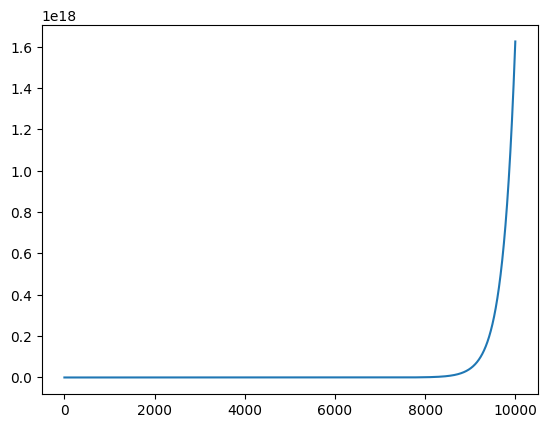

In [28]:
plt.plot(results[0:10000,1])

In [19]:
a = np.zeros((2,3))
b = np.array([1, 2, 3])
print(a)
print(b)
c = a.dot(b)
print(c)

[[0. 0. 0.]
 [0. 0. 0.]]
[1 2 3]
[0. 0.]


In [20]:
a = 1
b = 2
a=b
c = 3
b = c
a

2